# Анализ авторских профилей ЖЖ и построение прогнозной модели 

Для выполнения проекта была поставлена задача построить модель классификатора, который бы мог потенциально определить фейковую анкету среди остальных. 


## Загрузка библиотек

## <font color='green'>Review. Часть 1</font>

-       описание набора данных и признаков (на понятном русском, желательно с картинками) - 1 балл

<font color='green'>1 балл. 
</font>

-       первичный анализ признаков  - 3 балла

<font color='green'>3 балла. <br> <br>
</font>

-       первичный визуальный анализ признаков  - 3 балла

<font color='green'>2 балла. <br> 
Хотелось бы больше комментариев к графикам, какие результаты Вы нашли. 
Если есть где-то выбросы, то что Вы будете с ними делать и т.д.
</font>

-       если пришли к каким-то "инсайтам", обнаружили закономерности - изложите  - 3 балла

<font color='green'>2 балла <br> 
На текущий момент, в данных найдено мало интересного. Возможно стоит добавить данных, 
и посмотреть как изменяться зависимости.</font>

## <font color='green'>Итого: 8 баллов (округл.)</font>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import re

## Описание данных

В исходных данных содержится адрес блога, никнейм, вся информация, которую пользователь указал о себе (местонахождение, дата рождения и тд), а также тексты в блоге.
Материал - 2100 случайных авторских профилей из старого Живого Журнала (из нового пока недостаточно данных, т.ею это с качивание 2014 года). Для каждого автора проверялась доступность дневника, а также сохранность информации – ника, даты рождения, местонахождения и образования. 
Данные были проверены вручную и каждое изменение (удаление/удаление/замена данных) помечено.  
Ссылка: https://drive.google.com/file/d/0B600DBw1ZmZAUE93YVd4V3Mya1E/view?usp=sharing

### Список переменных

In [13]:
print(data.columns.values)

['URL' 'Nickname ' 'Birthdate' 'Location' 'School' 'Change_nickname'
 'Change_birthdate' 'Change_location' 'Change_schools' 'Name'
 'Gender_determined' 'Unavailable' 'Collective' 'Fake' 'Comment']


1. URL - адрес блога в момент выкачки (2013 год)
+ Nickname - никнейм автора блога
+ Birthdate - указанная дата рождения автора блога. Может содержать либо год рождения, либо дату (число и месяц), либо и то, и другое.
+ Location - указанное местонахождение автора (без унифицирования и обработки, as is)
+ School - указанное образование автора (школы, университеты, без обработки, as is)
+ Change_nickname - был ли изменен с момента выкачки никнейм (х - был изменен, 0 - был удален, 1 - был добавлен)
+ Change_birthdate - была ли изменена с момента выкачки дата рождения (х - была изменена, 0 - была удалена, 1 - была добавлена)
+ Change_location - было ли изменено с момента выкачки местоположение (х - было изменено, 0 - было удалено, 1 - было добавлено)
+ Change_schools - была ли изменена с момента выкачки информация об образовании (х - была изменена, 0 - была удалена, 1 - была добавлена)
+ Name - указанное имя автора (в отличие от ника, который является обязательным и составляет часть адреса блога, имя может быть не указано, а чаще фейковое)
+ Gender_determined - позволяет ли имя однозначно определить пол автора (1 - да, 0 - нет).
+ Unavailable - является ли блог недоступным на текущий момент (удален или заблокирован; 1 - да, 0 - нет).
+ Collective - является ли блог коллективным (1 - да, 0 - нет).
+ Fake - содержит ли информация профиля фейковые данные - очевидно ложное местоположение, дату и т.д. (1 - да, 0 - нет). Не касается фантазийной разметки - если пользователь сам указал, что учился в Хогвартсе, это true, а если в блоге стоит местоположение "New York", а в посте написано, что он принимает заказы на съемку в Симферополе - то это fake. 
+ Comment - комментарий разметчика (был удобен при ручной разметке, для обучения не нужен)

In [3]:
data = pd.read_csv(r'C:\Users\USER\Documents\JJeval5.csv', sep=';',  encoding='utf-8')
data.head()

,URL,Nickname,Birthdate,Location,School,Change_nickname,Change_birthdate,Change_location,Change_schools,Name,Gender_determined,Unavailable,Collective,Fake,Comment
0,http://ext_1036105.livejournal.com/profile,Ciklop1982,NaN,NaN,NaN,x,NaN,NaN,NaN,Дмитрий Ц,1,0.0,0.0,0.0,имя - Дмитрий Ц
1,http://goroshek2.livejournal.com/profile,goroshek2,14 May,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
2,http://ext_1778389.livejournal.com/profile,Михаил Козюков,11 August 1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
3,http://soffi_7.livejournal.com/profile,soffi_7,NaN,Москва; Москва; Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
4,http://modelturndactor.livejournal.com/profile,modelturndactor,28 February,Mesa; Arizona; United States,NaN,x,NaN,NaN,NaN,whats in a name?,0,0.0,0.0,0.0,имя - whats in a name?


### Первичный анализ признаков

In [15]:
data.describe()

,Unavailable,Collective,Fake
count,2100.000000,2100.000000,2100.000000
mean,0.028571,0.022857,0.005238
std,0.166638,0.149484,0.072202
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


Итого получаем, что недоступных нам на данный момент анкет - 3%
Есть также  2% дневников, которые ошибочно приняты за личные - это сообщества ЖЖ или публичные страницы заведений.
Полпроцента - содержат фейковые данные.

In [13]:
# посмотрим самые частотные локации
data['Location'].value_counts()

Russian Federation                                                                                                                                     99
Москва, Russian Federation                                                                                                                             53
United States                                                                                                                                          37
Москва, Москва, Russian Federation                                                                                                                     33
Ukraine                                                                                                                                                25
Moscow, Russian Federation                                                                                                                             14
California, United States                                                   

In [23]:
# А также самые частотные имена
data['Name'].value_counts().head(20)

Sarah                    5
Megan                    4
Laura                    3
Lisa                     3
jenny                    2
Alyssa                   2
Christopher              2
Nastya                   2
Kim                      2
Неизвестно Неизвестно    2
Andrew                   2
Kelly                    2
K                        2
Kate                     2
удален                   2
Chris                    2
Nicholas                 2
Mary                     2
Morgan                   2
Rebecca                  2
Name: Name, dtype: int64

In [21]:
# А теперь посчитаем, какая доля невыкачанных ников дает определение гендера

data['Gender_determined'].value_counts()


1    375
0    337
       1
dtype: int64

In [24]:
print("Процент ников, которые позволяют однозначно определить пол: ", 375/(375+337))
print("Процент ников, которые не позволяют однозначно определить пол: ", 337/(375+337))

Процент ников, которые позволяют однозначно определить пол:  0.526685393258427
Процент ников, которые не позволяют однозначно определить пол:  0.47331460674157305


In [32]:
# Посчитаем процент изменившейся информации по категориям
# Имена 
data[(data['Name'] !="")].count()
# Всего их 721 штук получилось

﻿URL                 2100
Nickname             2098
Birthdate            1460
Location             1328
School                255
Change_nickname        27
Change_birthdate       27
Change_location       105
Change_schools          7
Name                  721
Gender_determined     713
Unavailable          2100
Collective           2100
dtype: int64

In [31]:
# Дата рождения:
data['Change_birthdate'].value_counts()

0    13
x     7
1     7
dtype: int64

In [27]:
# Местонахождение:
data['Change_location'].value_counts()

x    77
0    18
1    10
dtype: int64

In [28]:
# Образование:
data['Change_schools'].value_counts()

0    4
x    2
1    1
dtype: int64

In [11]:
# Изменилось хоть что-то (кроме ника):
data[(data['Change_schools'] == '0') | (data['Change_location'] == '0') | (data['Change_birthdate'] == '0') | (data['Change_schools'] == '1') | (data['Change_location'] == '1') | (data['Change_birthdate'] == '1') | (data['Change_schools'] == 'x') | (data['Change_location'] == 'x') | (data['Change_birthdate'] == 'x') ].shape[0]

126

In [16]:
a = data[(data['Change_schools'] == '0') | (data['Change_location'] == '0') | (data['Change_birthdate'] == '0') | (data['Change_schools'] == '1') | (data['Change_location'] == '1') | (data['Change_birthdate'] == '1') | (data['Change_schools'] == 'x') | (data['Change_location'] == 'x') | (data['Change_birthdate'] == 'x') ].shape[0]/2100
print ("Столько профилей изменилось с момента скачивания: ", a)

Столько профилей изменилось с момента скачивания:  0.06


### Первичный визуальный анализ признаков

То же самое, что в предыдущей части, но визуально. Здесь строятся гистограммы распределения признаков, диаграммы рассеяния, бокс-плоты, матрицы корреляций и т.д. Отдельно надо поизучать, как целевой признак зависит от других. Очень полезно диаграммы рассеяния раскрашивать в зависимости от целевого класса (если это задача классификации). Плюсом будет PCA- или tSNE-представление данных и попытки интерпретации.

In [39]:
# посмотрим, как распределены дни рождения по годам- не смещена ли выборка. Известно, что средний возраст юзера ЖЖ - 30-35 лет. 
# т.е. годы рождения должны центрироваться вокруг отметки 1980-1985
# создадим новый признак - Birth_year
def birth_year(age):
    if re.search(r'\d{4}', str(age)):
        result = re.search(r'\d{4}', str(age))
        #print(result.group(0))
        return int(result.group(0))
    else:
        return None

In [40]:
birth_years = [birth_year(age) for age in data.Birthdate]

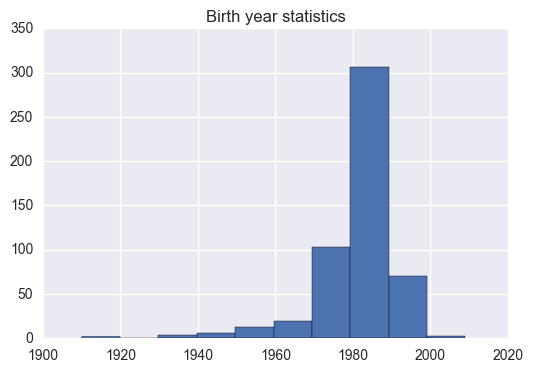

In [41]:
data['Birth_year'] = birth_years
data['Birth_year'].hist()
plt.title('Birth year statistics')
plt.show()


Примерно так и получилось. Видно, что возраст распределено нормально, относительно 1985 года. 

Теперь посмотрим, сколько признаков (имя, дата рождения, местоположение, образование) приходится в среднем на пользователя

In [54]:
# для этого создадим новый признак 'Info_count'
for i in range(2100):
    data.at[i,'Info_count'] = len(data.loc[i, ['Nickname', 'Birthdate', 'Location', 'School', 'Name']].dropna())

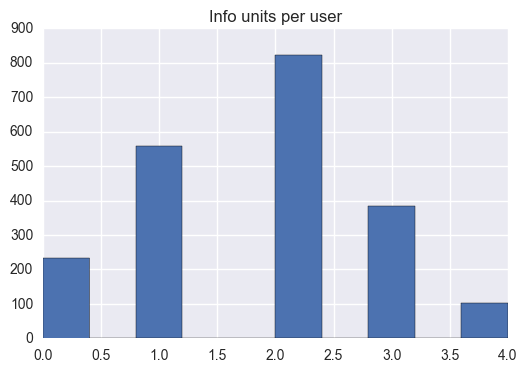

In [55]:
data['Info_count'].hist()
plt.title('Info units per user')
plt.show()

Теперь можно посмотреть, как зависит количество заполненных пунктов в анкете (то, что мы только что посчитали), от возраста, местонахождения.
Также проверим, зависят ли недостоверность данных и недоступность от этих данных.

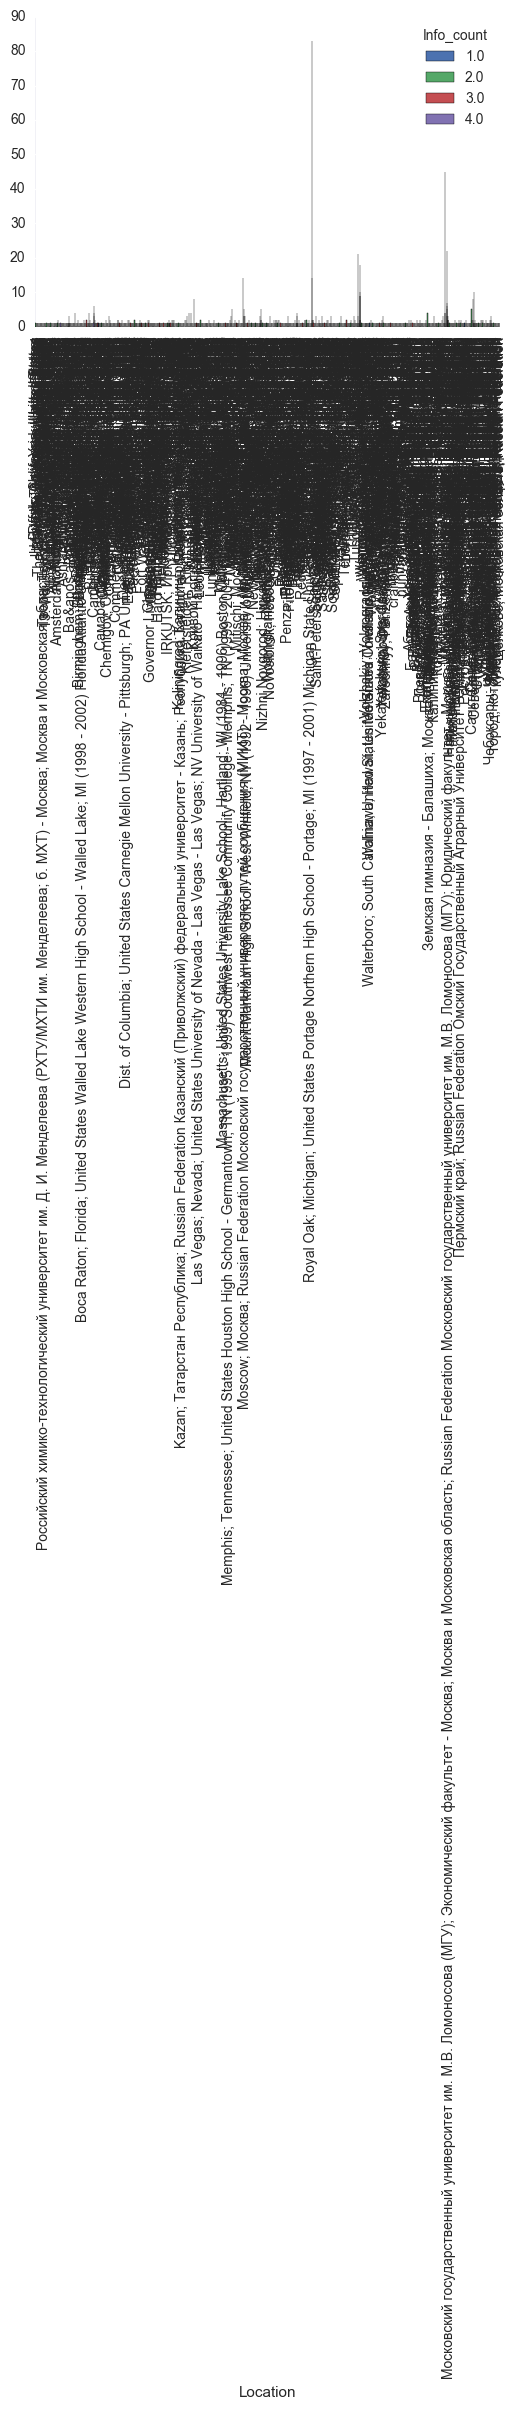

In [62]:
ct = pd.crosstab(data.Location, data['Info_count'])
ct.plot(kind='bar')

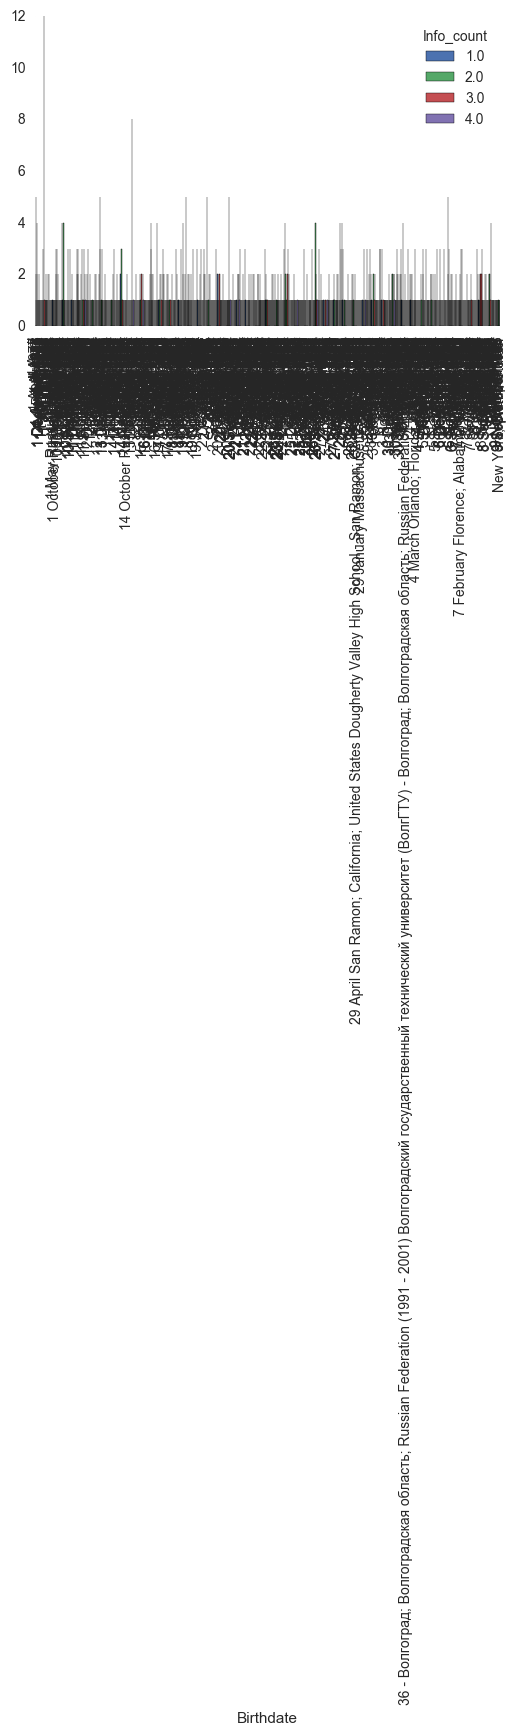

In [63]:
ct = pd.crosstab(data.Birthdate, data['Info_count'])
ct.plot(kind='bar')

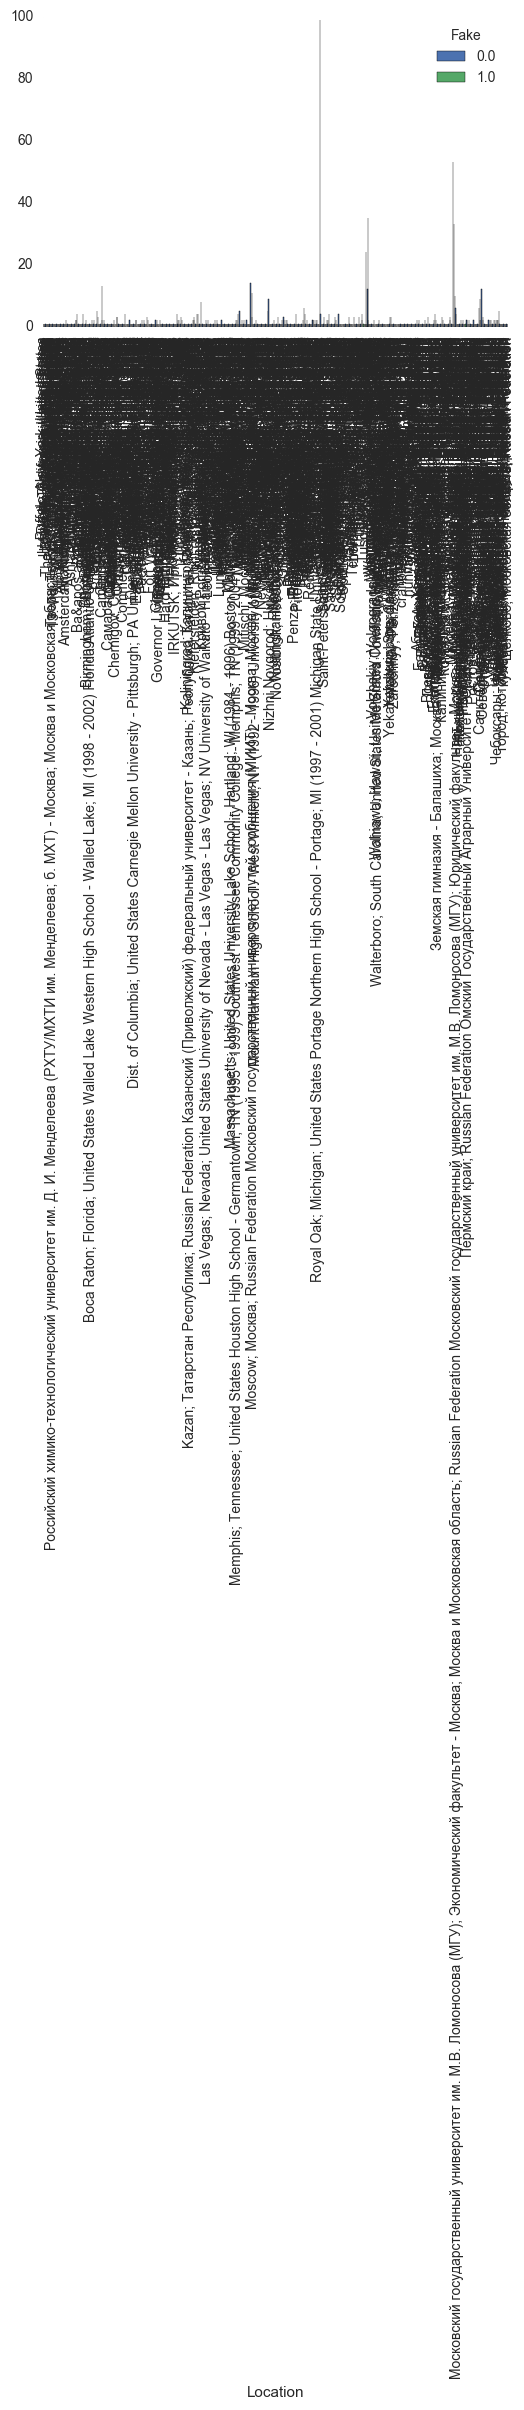

In [64]:
ct = pd.crosstab(data.Location, data['Fake'])
ct.plot(kind='bar')

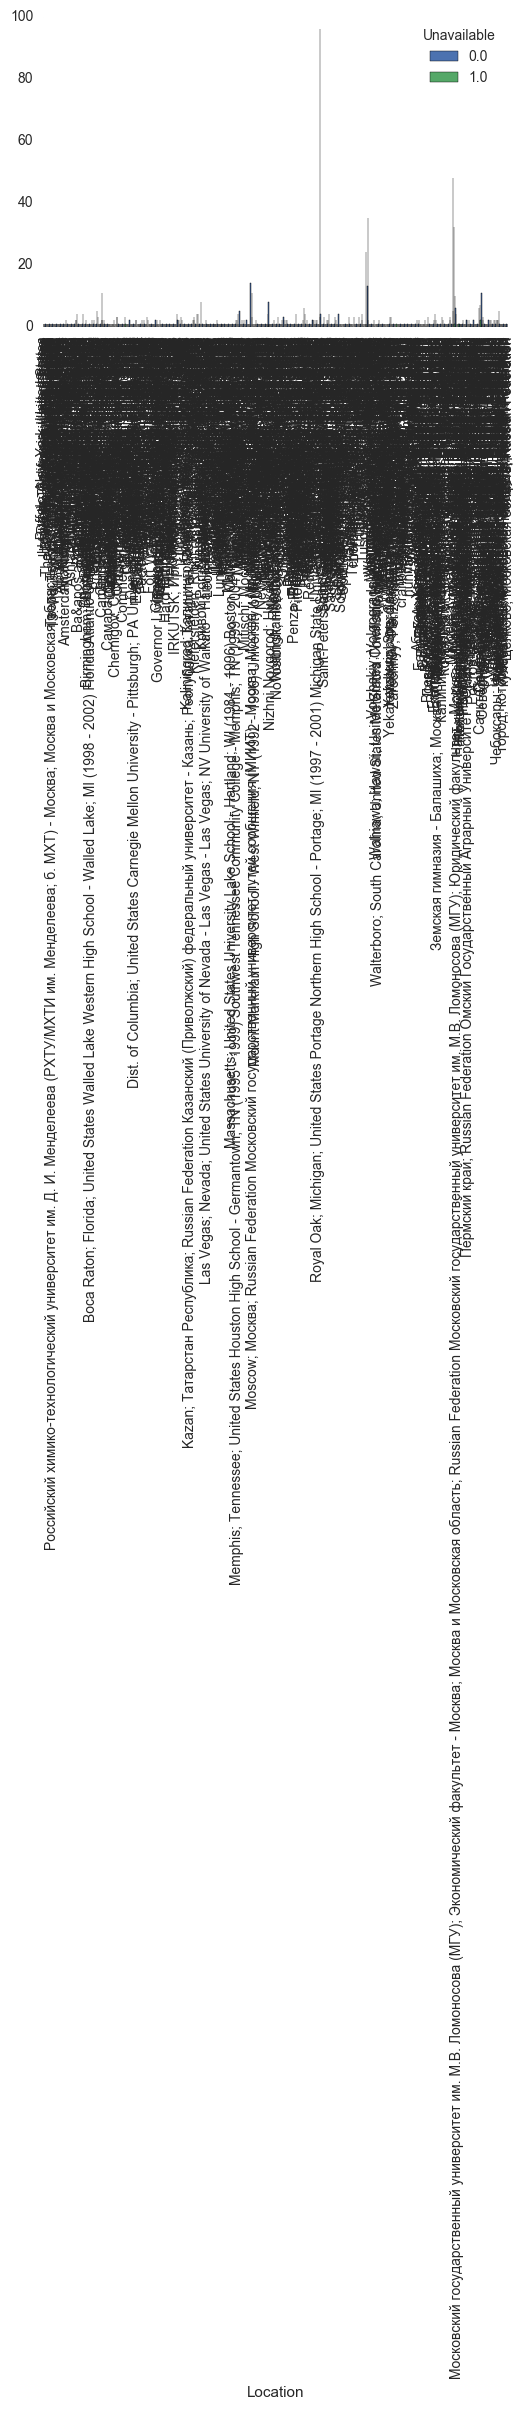

In [65]:
ct = pd.crosstab(data.Location, data['Unavailable'])
ct.plot(kind='bar')

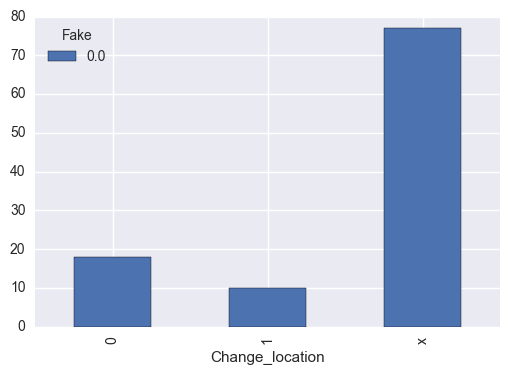

In [66]:
ct = pd.crosstab(data.Change_location, data['Fake'])
ct.plot(kind='bar')

Между фейковостью аккаунта и изменением местонахождения связи найти не получилось - в данных есть только случаи, когда аккаунты нефейковые.Та  же ситуация и с датой рождения:

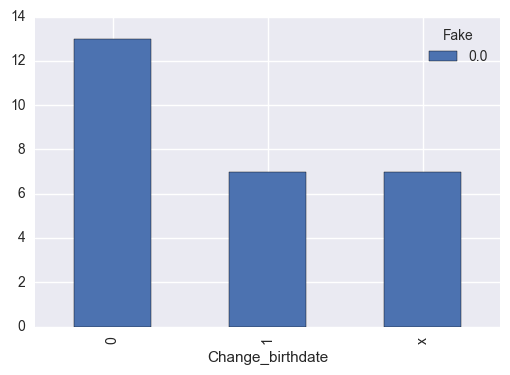

In [67]:
ct = pd.crosstab(data.Change_birthdate, data['Fake'])
ct.plot(kind='bar')

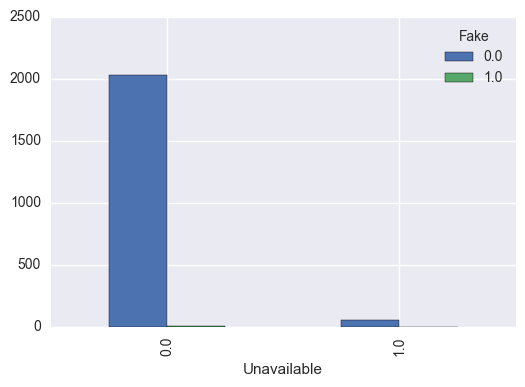

In [69]:
ct = pd.crosstab(data.Unavailable, data['Fake'])
ct.plot(kind='bar')

### Предположения и предложения:
В процессе анализа данных были выявлены следующие недостатки текущего набора признаков: 
1. если выкинуть все старые блоги, % русскоязычных резко возрастет - нужно было выкачивать дату создания блога
+ нужно было выкачивать имя - было выяснено, что в 53 % случаев оно позволяет однозначно определить гендер
+ был найден 1% шума - вместе с личными страницами выкачаны группы безо всякой пометки - это явный недостаток краулера.
+ количественных признаков пока недостаточно, как и недостаточно фейковых аккаунтов, чтобы выявить закономерности. данные очевидно надо добавлять и, возможно, пытаться кластеризовать, не используя ручную разметку.


Возможно, стоит добавить тексты авторов с морфологической разметкой и попытаться кластеризовать такие данные.